# CR Experiments for control qubit 3 + target qubit 1

using parts of: https://github.com/singular-value/optimizations_via_openpulse


In [1]:
# control qubit index
q1 = 1
control = q1

# target qubit index
q2 = 3
target = q2

In [2]:
# use cache data
use_cache = False

import os, json
data_dir = os.getcwd() + '\\CR_data_c1_t3\\'
#os.makedirs(data_dir)
#os.listdir(data_dir)

In [3]:
from copy import deepcopy
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle, pprint, qiskit
import scipy.optimize as opt
from qiskit import pulse, transpile, assemble, schedule, quantum_info as qi
from qiskit.pulse.library import gaussian_square
from qiskit.pulse.transforms import align_measures
from qiskit.ignis.verification import randomized_benchmarking as rb 
from qiskit.providers.ibmq.job import job_monitor
from qiskit.providers.jobstatus import JobStatus
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit.pulse.library import drag, GaussianSquare
from qiskit.visualization import SchedStyle
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.result import Result

# modules
from utils.cr_pulse_utils import create_cr_circuit, var_amp, var_phi
from utils.qpt_utils import create_qpt_experiment, extract_choi_matrix
from utils.rb_utils import create_rb_experiment, cache_circuit
from utils.analysis_utils import (cr_3rd_order_perturbation, local_fidelity_optimization, optimize_circuit, expectation_val, 
                                  hamiltonian_reconstruction,  plot_quantum_channel, ExperimentRunner)

In [4]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')
backend_name = 'ibmq_casablanca'

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# E1: Calibration of CR phase

In [5]:
max_cr_amplitude = 0.35 # maximum cross resonance amplitude in E1
alignment = 16 # sample number restriction

# initial cross resonance pulse parameters E1
cr_params = {'duration': 60 * alignment, 'amp': var_amp, 'phi': var_phi, 'sigma': 2 * alignment, 'risefall': 4 * alignment}

In [6]:
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()
cr_qubits = sorted([control, target])
qregs = qiskit.QuantumRegister(config.n_qubits)

u_index = config.control((control, target))[0].index 
print("control channel index:",u_index)

channels = [pulse.DriveChannel(control), pulse.DriveChannel(target), pulse.ControlChannel(u_index)] 
print(channels)

mem_ind = 0 if control > target else 1
print("index of memory slot at which the measurement data of target qubit is stored:",mem_ind)

control channel index: 3
[DriveChannel(1), DriveChannel(3), ControlChannel(3)]
index of memory slot at which the measurement data of target qubit is stored: 1


In [7]:
runner = ExperimentRunner(path=data_dir, backend=backend, cached=use_cache)

E1 Setup

In [8]:
# E_1_1 CR calibration circ
shots = 1024
cr_cal_circ, ext_inst_map, ext_basis_gates = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=True)

cr_cal_circ.draw(fold=-1, idle_wires=False)

┌────────────────┐┌───┐┌────────────────┐┌───┐
q0_1: ┤0               ├┤ X ├┤0               ├┤ X ├
      │  zx_p(amp,phi) │└───┘│  zx_m(amp,phi) │└───┘
q0_3: ┤1               ├─────┤1               ├─────
      └────────────────┘     └────────────────┘

In [9]:
# rough amp calibration

cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, 20)

# setup CR Rabi experiment with Z measurement
cr_rabi_circ = cr_cal_circ.copy()
cr_rabi_circ.measure_active()

cr_rabi_circs = []
for cind, cr_amp in enumerate(cr_amps):
    fixed_cr_circ = cr_rabi_circ.bind_parameters({var_amp: cr_amp, var_phi: 0})
    fixed_cr_circ.name = 'cr_rabi_circ_%d' % cind
    cr_rabi_circs.append(fixed_cr_circ)

transpiled_circuits = transpile(cr_rabi_circs, backend, basis_gates=ext_basis_gates, optimization_level=0)
scheds = schedule(transpiled_circuits, backend, inst_map=ext_inst_map)

qobj_1_1 = assemble(scheds, backend, meas_level=2, shots=shots)

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\compiler\assemble.py:304: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [10]:
#job_1_1_c3t1 = backend.run(qobj_1_1)
#job_1_1_c3t1.job_id()

In [36]:
#jobid_c1t3 = '604f4a7b0e63ea8ad337586e'
#job_1_1_c1t3 = backend.retrieve_job(jobid_c1t3)
#job_monitor(job_1_1_c3t1)
#result_1_1 = job_1_1_c1t3.result()

#jobid_c1t3 = '60535cae897a5e82df8dd776'
#job_1_1_c1t3 = backend.retrieve_job(jobid_c1t3)
#job_monitor(job_1_1_c3t1)
#result_1_1 = job_1_1_c3t1.result()

jobid_c1t3 ='605e5f205eb474663652b0c9'
#jobid_c1t3 = '60535cae897a5e82df8dd776'
#jobid_c1t3 = '604f4a7b0e63ea8ad337586e'
job_1_1_c1t3 = backend.retrieve_job(jobid_c1t3)
job_1_1_c1t3.status()
#result_1_1 = job_1_1_c1t3.result()

<JobStatus.DONE: 'job has successfully run'>

In [37]:
path = data_dir + "E_1_1_c1t3.json"

with open(path, 'w') as fp:
    json.dump(result_1_1.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    results_c3t1_dict = json.load(fp)
    result_1_1 = Result.from_dict(results_c3t1_dict) 

E_1_1 Analysis

In [38]:
def cr_fit_3rd_order_perturbation(x, c1, c2):
    fx = c1*x - c2*x**3
    return np.cos(2 * np.pi * fx)

def rough_amp_objective(x, params, opt_phase):
    fx = params[0] * x - params[1] * x**3
    return np.abs(opt_phase / 2 / np.pi - fx)

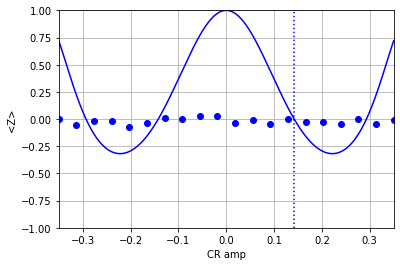

In [39]:
exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(result_1_1, mem_ind=target, exp_name='cr_rabi_circ_%d' % cind)

valid_inds = np.where(np.abs(cr_amps) < 0.35)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()

In [40]:
cr_pi2_amp

0.1421129818704015

In [41]:
# E_1_2: Phase calibration


cr_phases = np.linspace(-np.pi, np.pi, 20)

# setup phase sweep experiment with Y measurement under control state = |0>
cr_phase_circ0 = qiskit.QuantumCircuit(qregs)
cr_phase_circ0 += cr_cal_circ
cr_phase_circ0.barrier(qregs[control], qregs[target])
cr_phase_circ0.sdg(qregs[target])
cr_phase_circ0.h(qregs[target])
cr_phase_circ0.measure_active()

# setup phase sweep experiment with Y measurement under control state = |1>
cr_phase_circ1 = qiskit.QuantumCircuit(qregs)
cr_phase_circ1.x(qregs[control])
cr_phase_circ1 += cr_cal_circ
cr_phase_circ1.barrier(qregs[control], qregs[target])
cr_phase_circ1.sdg(qregs[target])
cr_phase_circ1.h(qregs[target])
cr_phase_circ1.measure_active()

cr_phase_circs = []
for cind, cr_phase in enumerate(cr_phases):
    # control state = 0
    fixed_cr_circ0 = cr_phase_circ0.bind_parameters({var_amp: cr_pi2_amp, var_phi: cr_phase})
    fixed_cr_circ0.name = 'phase_swp_%d_0' % cind
    cr_phase_circs.append(fixed_cr_circ0)
    # control state = 1
    fixed_cr_circ1 = cr_phase_circ1.bind_parameters({var_amp: cr_pi2_amp, var_phi: cr_phase})
    fixed_cr_circ1.name = 'phase_swp_%d_1' % cind
    cr_phase_circs.append(fixed_cr_circ1)

transpiled_circuits = transpile(cr_phase_circs, backend, basis_gates=ext_basis_gates, optimization_level=0)
scheds = schedule(transpiled_circuits, backend, inst_map=ext_inst_map)

qobj_1_2 = assemble(scheds, backend, meas_level=2, shots=shots)

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\compiler\assemble.py:304: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [58]:
path = data_dir + "E_1_2_a_c3t1.json"

#with open(path, 'w') as fp:
    #json.dump(result_1_2.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    resdict = json.load(fp)
    result_1_2 = Result.from_dict(resdict) 

E_1_2 Analysis

In [59]:
def cos_fit_00(x, a, b):
    return a * np.cos(x - b + np.pi)

def cos_fit_10(x, a, b):
    return a * np.cos(x - b)

In [60]:
exp_y0 = np.zeros_like(cr_phases)
exp_y1 = np.zeros_like(cr_phases)

for cind in range(len(cr_phases)):
    exp_y0[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_0' % cind)
    exp_y1[cind] = expectation_val(result_1_2, mem_ind=mem_ind, exp_name='phase_swp_%d_1' % cind)

params0, _ = opt.curve_fit(cos_fit_00, xdata=cr_phases, ydata=exp_y0, bounds=([0, -np.pi], [1, np.pi]))
params1, _ = opt.curve_fit(cos_fit_10, xdata=cr_phases, ydata=exp_y1, bounds=([0, -np.pi], [1, np.pi]))

phi_opt = (params0[1] + params1[1]) / 2

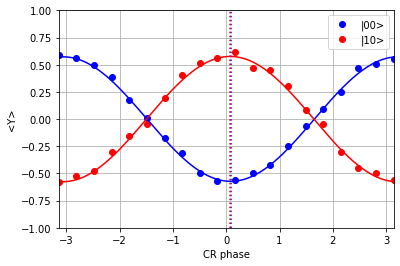

In [61]:
x_interp = np.linspace(cr_phases[0], cr_phases[-1], 1000)
plt.plot(cr_phases, exp_y0, 'o', color='b', label='|00>')
plt.plot(cr_phases, exp_y1, 'o', color='r', label='|10>')
plt.plot(x_interp, cos_fit_00(x_interp, *params0), 'b')
plt.plot(x_interp, cos_fit_10(x_interp, *params1), 'r')
plt.plot([params0[1], params0[1]], [-1, 1], 'b:')
plt.plot([params1[1], params1[1]], [-1, 1], 'r:')
plt.xlim(cr_phases[0], cr_phases[-1])
plt.ylim(-1, 1)
plt.xlabel('CR phase')
plt.ylabel('<Y>')
plt.grid()
plt.legend()

In [62]:
phi_opt

0.07814449823460476

In [63]:
# fix CR phase
cr_params['phi'] = phi_opt

# E_2: Amplitude sweep process tomography

In [64]:
shots = 2048

# cross resonance amplitudes to measure process tomography
cr_amplitudes = np.linspace(0, max_cr_amplitude, 6)

## 2-1. CR1 circuit

In [65]:
cr1_circ, ext_inst_map_cr1, ext_basis_gates_cr1 = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=False)

cr1_circ.draw(fold=-1, idle_wires=False)

┌────────────┐
q0_1: ┤0           ├
      │  zx_p(amp) │
q0_3: ┤1           ├
      └────────────┘

In [66]:
# setup CR amplitude sweep for QPT
qpt_cr1_circs = []
for cr_amp in cr_amplitudes:
    fixed_cr_circ = cr1_circ.bind_parameters({var_amp: cr_amp})
    qpt_cr1_circs.append(fixed_cr_circ)

# create QPT experiments
qobj_2_1, qcs, meas_labels = create_qpt_experiment(
    target_circuits=qpt_cr1_circs,
    control=control,
    target=target,
    backend=backend,
    inst_map=ext_inst_map_cr1,
    basis_gate=ext_basis_gates_cr1,
    shots=shots)

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\compiler\assemble.py:304: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [54]:
#result_2_1 = runner.run(qobj_2_1, '2-1_cr1_qpts')

In [67]:
#jobid_2_1_a = '605e5c53098cdff1051124e6'
#job_2_1_a = backend.retrieve_job(jobid_2_1_a)
#job_2_1_a.status()

#result_2_1_a = job_2_1_a.result()

path = data_dir + "E_2_1_a_c3t1.json"

#with open(path, 'w') as fp:
    #json.dump(result_2_1_a.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    resdict = json.load(fp)
    result_2_1_a = Result.from_dict(resdict) 

In [68]:
#jobid_2_1_b = "605081daac489097eb2a52ea"
#job_2_1_b = backend.retrieve_job(jobid_2_1_b)
#job_2_1_b.status()

#result_2_1_b = job_2_1_b.result()

path = data_dir + "E_2_1_b_c3t1.json"

#with open(path, 'w') as fp:
    #json.dump(result_2_1_b.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    resdict = json.load(fp)
    result_2_1_b = Result.from_dict(resdict) 

Analysis

In [69]:
result_2_1 = result_2_1_a

cr1_chois = [choi for choi in extract_choi_matrix(result_2_1, qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/2-1_a_cr1_qpts_choi_mat.npy' % data_dir, [cr1_choi.data for cr1_choi in cr1_chois])

readout fidelity = 0.946


In [70]:
result_2_1 = result_2_1_b

cr1_chois = [choi for choi in extract_choi_matrix(result_2_1, qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/2-1_b_cr1_qpts_choi_mat.npy' % data_dir, [cr1_choi.data for cr1_choi in cr1_chois])

readout fidelity = 0.964


## 2_2: CR2 circuit

In [73]:
cr2_circ, ext_inst_map_cr2, ext_basis_gates_cr2 = create_cr_circuit(
    cross_resonance_params=cr_params,
    control=control,
    target=target,
    u_index=u_index,
    q_regs=qregs,
    inst_map=defaults.instruction_schedule_map,
    basis_gates=config.basis_gates,
    use_echo=True)

cr2_circ.draw(fold=-1, idle_wires=False)

┌────────────┐┌───┐┌────────────┐┌───┐
q0_1: ┤0           ├┤ X ├┤0           ├┤ X ├
      │  zx_p(amp) │└───┘│  zx_m(amp) │└───┘
q0_3: ┤1           ├─────┤1           ├─────
      └────────────┘     └────────────┘

In [74]:
# setup CR amplitude sweep for QPT
qpt_cr2_circs = []
for cr_amp in cr_amplitudes:
    fixed_cr_circ = cr2_circ.bind_parameters({var_amp: cr_amp})
    qpt_cr2_circs.append(fixed_cr_circ)

# create QPT experiments
qobj_2_2, qcs, meas_labels = create_qpt_experiment(
    target_circuits=qpt_cr2_circs,
    control=control,
    target=target,
    backend=backend,
    inst_map=ext_inst_map_cr2,
    basis_gate=ext_basis_gates_cr2,
    shots=shots)

In [75]:
#result_2_2 = runner.run(qobj_2_2, '2-2_cr2_qpts')

In [76]:
#jobid_2_2_a ='605e5d1f3fc552a2d1097bd1'
#job_2_2_a = backend.retrieve_job(jobid_2_2_a)
#job_2_2_a.status()

#result_2_2_a = job_2_2_a.result()

path = data_dir + "E_2_2_a_c3t1.json"

#with open(path, 'w') as fp:
    #json.dump(result_2_2_a.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    resdict = json.load(fp)
    result_2_2_a = Result.from_dict(resdict) 

In [77]:
#jobid_2_2_b = "605a0c2d6b0b89800bada390" 
#job_2_2_b = backend.retrieve_job(jobid_2_2_b)
#job_2_2_b.status()

#result_2_2_b = job_2_2_b.result()

path = data_dir + "E_2_2_b_c3t1.json"

#with open(path, 'w') as fp:
    #json.dump(result_2_2_b.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    resdict = json.load(fp)
    result_2_2_b = Result.from_dict(resdict) 

In [78]:
result_2_2 = result_2_2_a 

cr2_chois = [choi for choi in extract_choi_matrix(result_2_2, qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/2-2_a_cr2_qpts_choi_mat.npy' % data_dir, [cr2_choi.data for cr2_choi in cr2_chois])

readout fidelity = 0.951


In [79]:
result_2_2 = result_2_2_b

cr2_chois = [choi for choi in extract_choi_matrix(result_2_2, qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/2-2_b_cr2_qpts_choi_mat.npy' % data_dir, [cr2_choi.data for cr2_choi in cr2_chois])

readout fidelity = 0.939


# E_3: Snapshot of system status

In [80]:
def average_amp(x):
    cr_pulse_temp = gaussian_square(duration=cr_params['duration'],
                                    amp=x,
                                    sigma=cr_params['sigma'],
                                    risefall=cr_params['risefall'])
    return np.sum(cr_pulse_temp.samples.real) / cr_params['duration']

In [81]:
import datetime

anharmonicity = [properties.qubit_property(qind)['anharmonicity'][0] for qind in range(config.n_qubits)]
experiment_date = datetime.datetime.fromisoformat(result_1_1.date) if isinstance(result_1_1.date, str) else result_1_1.date
properties_at_runtime = backend.properties(datetime=experiment_date)

# Note that u2 and u3 gates are no longer used in the recent IBM Quantum backends.
experiment_conditions = {
    'backend_update': properties_at_runtime.last_update_date,
    'backend_cnot_fidelity': 1 - properties_at_runtime.gate_error('cx', qubits=(control, target)),
    'backend_cnot_gate_length': properties_at_runtime.gate_length('cx', qubits=(control, target)),
    'control_gate_errors': {'u2': properties_at_runtime.gate_error('sx', qubits=control), 
                            'u3': 2. * properties_at_runtime.gate_error('sx', qubits=control)},
    'target_gate_errors': {'u2': properties_at_runtime.gate_error('sx', qubits=control), 
                           'u3': 2. * properties_at_runtime.gate_error('sx', qubits=control)},
    'control_qubit_freq': properties_at_runtime.frequency(control),
    'target_qubit_freq': properties_at_runtime.frequency(target),
    'control_qubit_anharmonicity': anharmonicity[control],
    'target_qubit_anharmonicity': anharmonicity[target],
    'delta': properties_at_runtime.frequency(control) - properties_at_runtime.frequency(target),
    'control_qubit_t1': properties_at_runtime.qubit_property(control)['T1'][0],
    'target_qubit_t1': properties_at_runtime.qubit_property(target)['T1'][0],
    'control_qubit_t2': properties_at_runtime.qubit_property(control)['T2'][0],
    'target_qubit_t2': properties_at_runtime.qubit_property(target)['T2'][0],    
    'cr_per_pulse_duration': cr_params['duration'] * config.dt,
    'cr_amplitudes': cr_amplitudes,
    'avg_amplitudes': [average_amp(amp) for amp in cr_amplitudes],
    'cr_params': {key: val if isinstance(val, (int, float)) else 'var' for key, val in cr_params.items()}
}

<ipython-input-81-e70495cb7083>:5: UserWarning: Unless a UTC timezone information is present, the parameter `datetime`is now expected to be in local time instead of UTC.
  properties_at_runtime = backend.properties(datetime=experiment_date)


# E_4: Hamiltonian estimation

Setup: Note that the first and second character in `puali_labels` will be swapped if the index of the control qubit is smaller than the target qubit.

In [83]:
cr_t = experiment_conditions['cr_per_pulse_duration']
delta = 2 * np.pi * experiment_conditions['delta']
alpha_c = 2 * np.pi * experiment_conditions['control_qubit_anharmonicity']
alpha_t = 2 * np.pi * experiment_conditions['target_qubit_anharmonicity']
pulse_avg_amplitude = experiment_conditions['avg_amplitudes']

pauli_labels = ['ZX', 'ZY', 'ZZ', 'ZI', 'IX', 'IY', 'IZ']
colors = ['b', 'g', 'r', 'orange', 'c', 'y', 'm']
markers = ['o', 'v', '^', 's', 'p', 'h', 'X']

In [84]:
fitters = {}
for pauli_label in pauli_labels:
    term_fitter = partial(cr_3rd_order_perturbation, delta=delta, alpha_c=alpha_c, alpha_t=alpha_t, pauli=pauli_label)
    fitters[pauli_label] = term_fitter

## 4_1: CR1 circuit

In [85]:
cr1_gate_time = cr_t

phase_guess = [0, 1, 5, 9, 20, 32]
shift_oper = 'ZI'

n_exp = len(cr1_chois)

In [86]:
cr1_ham, fids = hamiltonian_reconstruction(cr1_chois, pauli_labels, cr1_gate_time, phase_guess, shift_oper)
print('F_avg between original Choi matrix and U of estimated Hamiltonian:\n%s\non average %s' % (fids, np.mean(fids)))

w_opt = -5.769e-08, cost_func = 3.490e-09, generator norm = 6.065e+00
Commutator [S, S_H] norm = 6.980e-09
w_opt = 2.870e-07, cost_func = 1.662e-08, generator norm = 3.186e+00
Commutator [S, S_H] norm = 3.313e-08
w_opt = 6.522e+00, cost_func = 8.773e-02, generator norm = 6.248e-01
Commutator [S, S_H] norm = 4.005e-02
w_opt = 7.046e+00, cost_func = 5.490e-02, generator norm = -4.361e+00
Commutator [S, S_H] norm = 7.411e-02
w_opt = 1.961e+01, cost_func = 7.298e-02, generator norm = -1.439e+00
Commutator [S, S_H] norm = 1.003e-01
w_opt = 3.200e+01, cost_func = 7.567e-02, generator norm = 3.189e-01
Commutator [S, S_H] norm = 8.331e-02
F_avg between original Choi matrix and U of estimated Hamiltonian:
[0.9971925909290487, 0.979215192321556, 0.9199502862723261, 0.4582154779214741, 0.40199912191313214, 0.7514169525596748]
on average 0.7513316036528686


In [87]:
j_guess = 1.0e6
c_guess = 200e6

cr1_params, conv = opt.curve_fit(fitters['ZX'], pulse_avg_amplitude, cr1_ham['ZX'], p0=[2*np.pi*j_guess, 2*np.pi*c_guess])
stdev = np.sqrt(np.diag(conv))[0]/2/np.pi/1e6

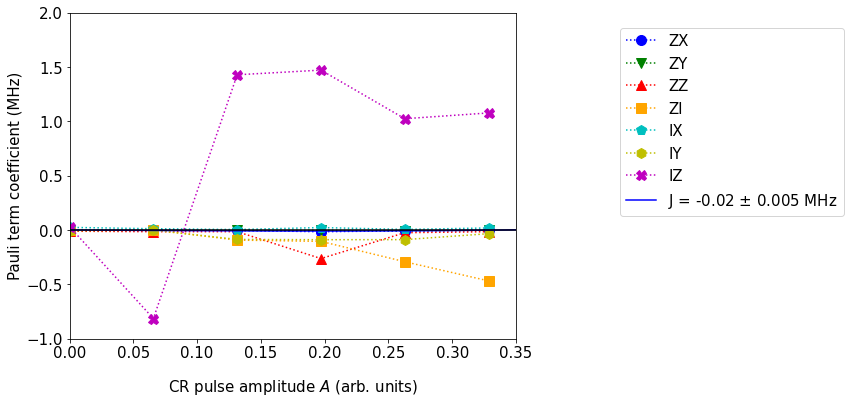

In [88]:
x_interp = np.linspace(0, 1, 100)
zi_scale = 0.01

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

for pauli_label, color, marker in zip(pauli_labels, colors, markers):
    if pauli_label == 'ZI':
        ax1.plot(pulse_avg_amplitude, zi_scale * cr1_ham[pauli_label]/2/np.pi/1e6,
                 '%s:' % marker, ms=10, color=color, label=pauli_label)
    else:
        ax1.plot(pulse_avg_amplitude, cr1_ham[pauli_label]/2/np.pi/1e6,
                 '%s:' % marker, ms=10, color=color, label=pauli_label)

# fit models
ax1.plot(x_interp, fitters['ZX'](x_interp, *cr1_params)/2/np.pi/1e6,
         color='b', label='J = %.2f $\pm$ %.3f MHz' % (cr1_params[0] / 2 / np.pi / 1e6, stdev))

ax1.plot([0, 1], [0, 0], 'k-')
ax1.set_xlabel(r'CR pulse amplitude $A$ (arb. units)', fontsize=15)
ax1.set_ylabel(r'Pauli term coefficient (MHz)', fontsize=15)
ax1.set_xlim(0, max_cr_amplitude)
ax1.set_ylim(-1, 2)
ax1.tick_params(labelsize=15)

ax1.xaxis.set_label_coords(0.5, -0.12)

ax1.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=1, fontsize=15)

## 4_2: CR-2 Circuit

In [89]:
cr2_gate_time = 2 * cr_t

phase_guess = [0, 0, 0, 0, -1, -1]
shift_oper = 'ZX'

n_exp = len(cr2_chois)

In [90]:
cr2_ham, fids = hamiltonian_reconstruction(cr2_chois, pauli_labels, cr2_gate_time, phase_guess, shift_oper)
print('F_avg between original Choi matrix and U of estimated Hamiltonian:\n%s\non average %s' % (fids, np.mean(fids)))

w_opt = -6.141e-08, cost_func = 3.955e-09, generator norm = 6.126e+00
Commutator [S, S_H] norm = 7.909e-09
w_opt = -4.883e-07, cost_func = 2.520e-07, generator norm = 3.280e+00
Commutator [S, S_H] norm = 5.038e-07
w_opt = -7.777e+01, cost_func = 1.065e+00, generator norm = -4.346e-01
Commutator [S, S_H] norm = 1.370e+00
w_opt = -1.278e-06, cost_func = 1.731e-06, generator norm = 5.858e-01
Commutator [S, S_H] norm = 3.450e-06
w_opt = -3.241e-11, cost_func = 5.380e-11, generator norm = 2.544e+00
Commutator [S, S_H] norm = 1.070e-10
w_opt = -1.240e-08, cost_func = 2.326e-08, generator norm = 2.371e+00
Commutator [S, S_H] norm = 4.619e-08
F_avg between original Choi matrix and U of estimated Hamiltonian:
[0.9968331209363208, 0.9918694064308422, 0.3994454962113597, 0.9918329097947879, 0.9872634280947675, 0.9913619554341618]
on average 0.8931010528170399


In [91]:
j_guess = 1.0e6
c_guess = 200e6

cr2_params, conv = opt.curve_fit(fitters['ZX'], pulse_avg_amplitude, cr2_ham['ZX'], p0=[2*np.pi*j_guess, 2*np.pi*c_guess])
stdev = np.sqrt(np.diag(conv))[0]/2/np.pi/1e6

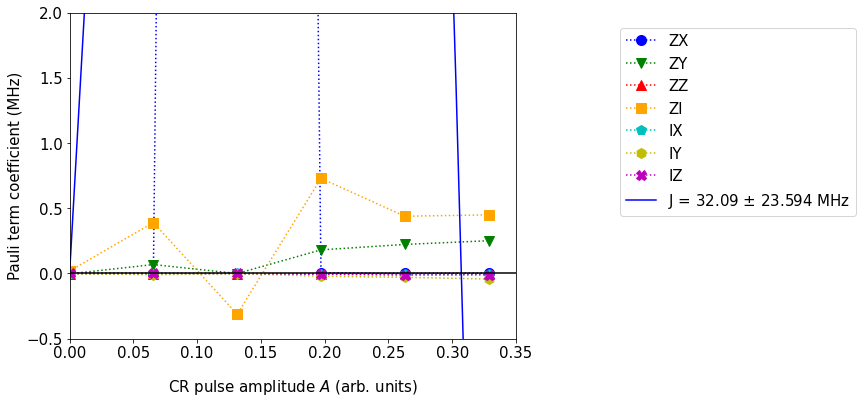

In [92]:
x_interp = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

for pauli_label, color, marker in zip(pauli_labels, colors, markers):
    ax1.plot(pulse_avg_amplitude, cr2_ham[pauli_label]/2/np.pi/1e6,
             '%s:' % marker, ms=10, color=color, label=pauli_label)

# fit models
ax1.plot(x_interp, fitters['ZX'](x_interp, *cr2_params)/2/np.pi/1e6,
         color='b', label='J = %.2f $\pm$ %.3f MHz' % (cr2_params[0] / 2 / np.pi / 1e6, stdev))

ax1.plot([0, 1], [0, 0], 'k-')
ax1.set_xlabel(r'CR pulse amplitude $A$ (arb. units)', fontsize=15)
ax1.set_ylabel(r'Pauli term coefficient (MHz)', fontsize=15)
ax1.set_xlim(0, max_cr_amplitude)
ax1.set_ylim(-0.5, 2)
ax1.tick_params(labelsize=15)

ax1.xaxis.set_label_coords(0.5, -0.12)

ax1.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=1, fontsize=15)

# E_5: Local fidelity optimization

In [93]:
shots = 2048

In [94]:
def cr_amp_objective(x, params, gate_time):
    x_avg = average_amp(x)
    return np.abs(0.5 * np.pi - fitters['ZX'](x_avg, *params) * gate_time)

In [95]:
control_logical_ind, target_logical_ind = (1, 0) if control > target else (0, 1)

In [96]:
# create reference quantum channel of CNOT.
# after measuring Choi matrix at the optimal CR pulse amplitude,
# optimize pre and post local rotations so that measured Choi matrix becomes CNOT.

ref_cnot_f = qiskit.QuantumCircuit(2)
ref_cnot_f.cx(control_logical_ind, target_logical_ind)
ref_cnot_f_oper = qi.Operator(ref_cnot_f)

ref_cnot_b = qiskit.QuantumCircuit(2)
ref_cnot_b.cx(target_logical_ind, control_logical_ind)
ref_cnot_b_oper = qi.Operator(ref_cnot_b)

## 5_1: Measure QPTs at optimal amplitude

In [97]:
# find optimal CR amp from the ZX fit: CR1
cr1_amp_opt = opt.dual_annealing(cr_amp_objective, x0=[0], bounds=[(0, 0.35)], args=(cr1_params, cr1_gate_time))
cr1_circ_zx90 = cr1_circ.bind_parameters({var_amp: cr1_amp_opt.x[0]})

cr1_circ_zx90.draw(fold=-1, idle_wires=False)

┌──────────┐
q0_1: ┤0         ├
      │  zx_p(0) │
q0_3: ┤1         ├
      └──────────┘

In [98]:
# find optimal CR amp from the ZX fit: CR2
cr2_amp_opt = opt.dual_annealing(cr_amp_objective, x0=[0], bounds=[(0, 0.35)], args=(cr2_params, cr2_gate_time))
cr2_circ_zx90 = cr2_circ.bind_parameters({var_amp: cr2_amp_opt.x[0]})

cr2_circ_zx90.draw(fold=-1, idle_wires=False)

┌────────────────────────────┐┌───┐┌────────────────────────────┐┌───┐
q0_1: ┤0                           ├┤ X ├┤0                           ├┤ X ├
      │  zx_p(0.00361768292324051) │└───┘│  zx_m(0.00361768292324051) │└───┘
q0_3: ┤1                           ├─────┤1                           ├─────
      └────────────────────────────┘     └────────────────────────────┘

In [99]:
# create QPT schedule
cr1_sched_opt, qcs1, meas_labels = create_qpt_experiment(
    target_circuits=cr1_circ_zx90,
    control=control,
    target=target,
    backend=backend,
    mit_readout=True,
    inst_map=ext_inst_map_cr1,
    basis_gate=ext_basis_gates_cr1,
    shots=shots, 
    return_schedule=True
)

cr2_sched_opt, qcs2, _ = create_qpt_experiment(
    target_circuits=cr2_circ_zx90,
    control=control,
    target=target,
    backend=backend,
    mit_readout=False,
    inst_map=ext_inst_map_cr2,
    basis_gate=ext_basis_gates_cr2,
    shots=shots, 
    return_schedule=True
)

# combine two QPT experiments and readout error mitigation experiments
bind_scheds = align_measures(cr1_sched_opt + cr2_sched_opt, max_calibration_duration=0)
bind_qcs = qcs1 + qcs2

qobj_5_1 = qiskit.assemble(bind_scheds, backend=backend, meas_level=2, shots=shots)

C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\compiler\assemble.py:304: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [100]:
#result_5_1 = runner.run(qobj_5_1, '5-1_qpt_zx90')

In [103]:
#jobid_5_1_a = '605e5de2098cdf4c061124f5'
#job_5_1_a = backend.retrieve_job(jobid_5_1_a)
#job_5_1_a.status()

#result_5_1_a = job_5_1_a.result()

path = data_dir + "E_5_1_a_c3t1.json"

#with open(path, 'w') as fp:
    #json.dump(result_5_1_a.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    resdict = json.load(fp)
    result_5_1_a = Result.from_dict(resdict) 

In [105]:
#jobid_5_1_b = "605c835c6b0b89a861adc1ce"
#job_5_1_b = backend.retrieve_job(jobid_5_1_b)
#job_5_1_b.status()

#result_5_1_b = job_5_1_b.result()

path = data_dir + "E_5_1_b_c3t1.json"

#with open(path, 'w') as fp:
    #json.dump(result_5_1_b.to_dict(), fp,default=str)
    
with open(path, 'r') as fp:
    resdict = json.load(fp)
    result_5_1_b = Result.from_dict(resdict) 

Analysis

In [106]:
result_5_1 = result_5_1_a

cr1_choi_opt, cr2_choi_opt = [choi for choi in extract_choi_matrix(result_5_1, bind_qcs, meas_labels)]

if not use_cache:
    np.save('%s/5-1_a_zx90_choi_mat.npy' % data_dir, [cr1_choi_opt.data, cr2_choi_opt.data])

readout fidelity = 0.946


In [107]:
result_5_1 = result_5_1_b

cr1_choi_opt, cr2_choi_opt = [choi for choi in extract_choi_matrix(result_5_1, bind_qcs, meas_labels)]

if not use_cache:
    np.save('%s/5-1_b_zx90_choi_mat.npy' % data_dir, [cr1_choi_opt.data, cr2_choi_opt.data])

readout fidelity = 0.953


## 5_2: Local fidelity optimization
Note that there are multiple optimal U3 sets and retult may change for each execution.

In [108]:
# optimize local U3 rotations to realize CNOT: CR1 forward order (control, target)
if use_cache:
    with open('%s/cr1_cnot_f_params.npy' % data_dir, 'rb') as fp:
        cr1_cnot_f_params = np.load(fp)
else:
    cr1_cnot_f_params = local_fidelity_optimization(cr1_choi_opt, ref_cnot_f_oper)
    np.save('%s/cr1_cnot_f_params.npy' % data_dir, cr1_cnot_f_params)

cr1_cnot_f = optimize_circuit(cr1_circ_zx90, control, target, cr1_cnot_f_params)
cr1_cnot_f.draw(fold=-1, idle_wires=False)

Original F_avg: 0.39936
Optimized F_avg: 0.60249


┌─────────────────────────────┐┌──────────┐┌───────────────────────────┐
q0_1: ┤ U3(0.25049,-1.2487,-1.0708) ├┤0         ├┤ U3(0.27312,2.5847,-1.841) ├
      └─────┬──────────────────┬────┘│  zx_p(0) │├───────────────────────────┤
q0_3: ──────┤ U3(-1.7821,π,-π) ├─────┤1         ├┤ U3(-1.5952,0.21865,1.536) ├
            └──────────────────┘     └──────────┘└───────────────────────────┘

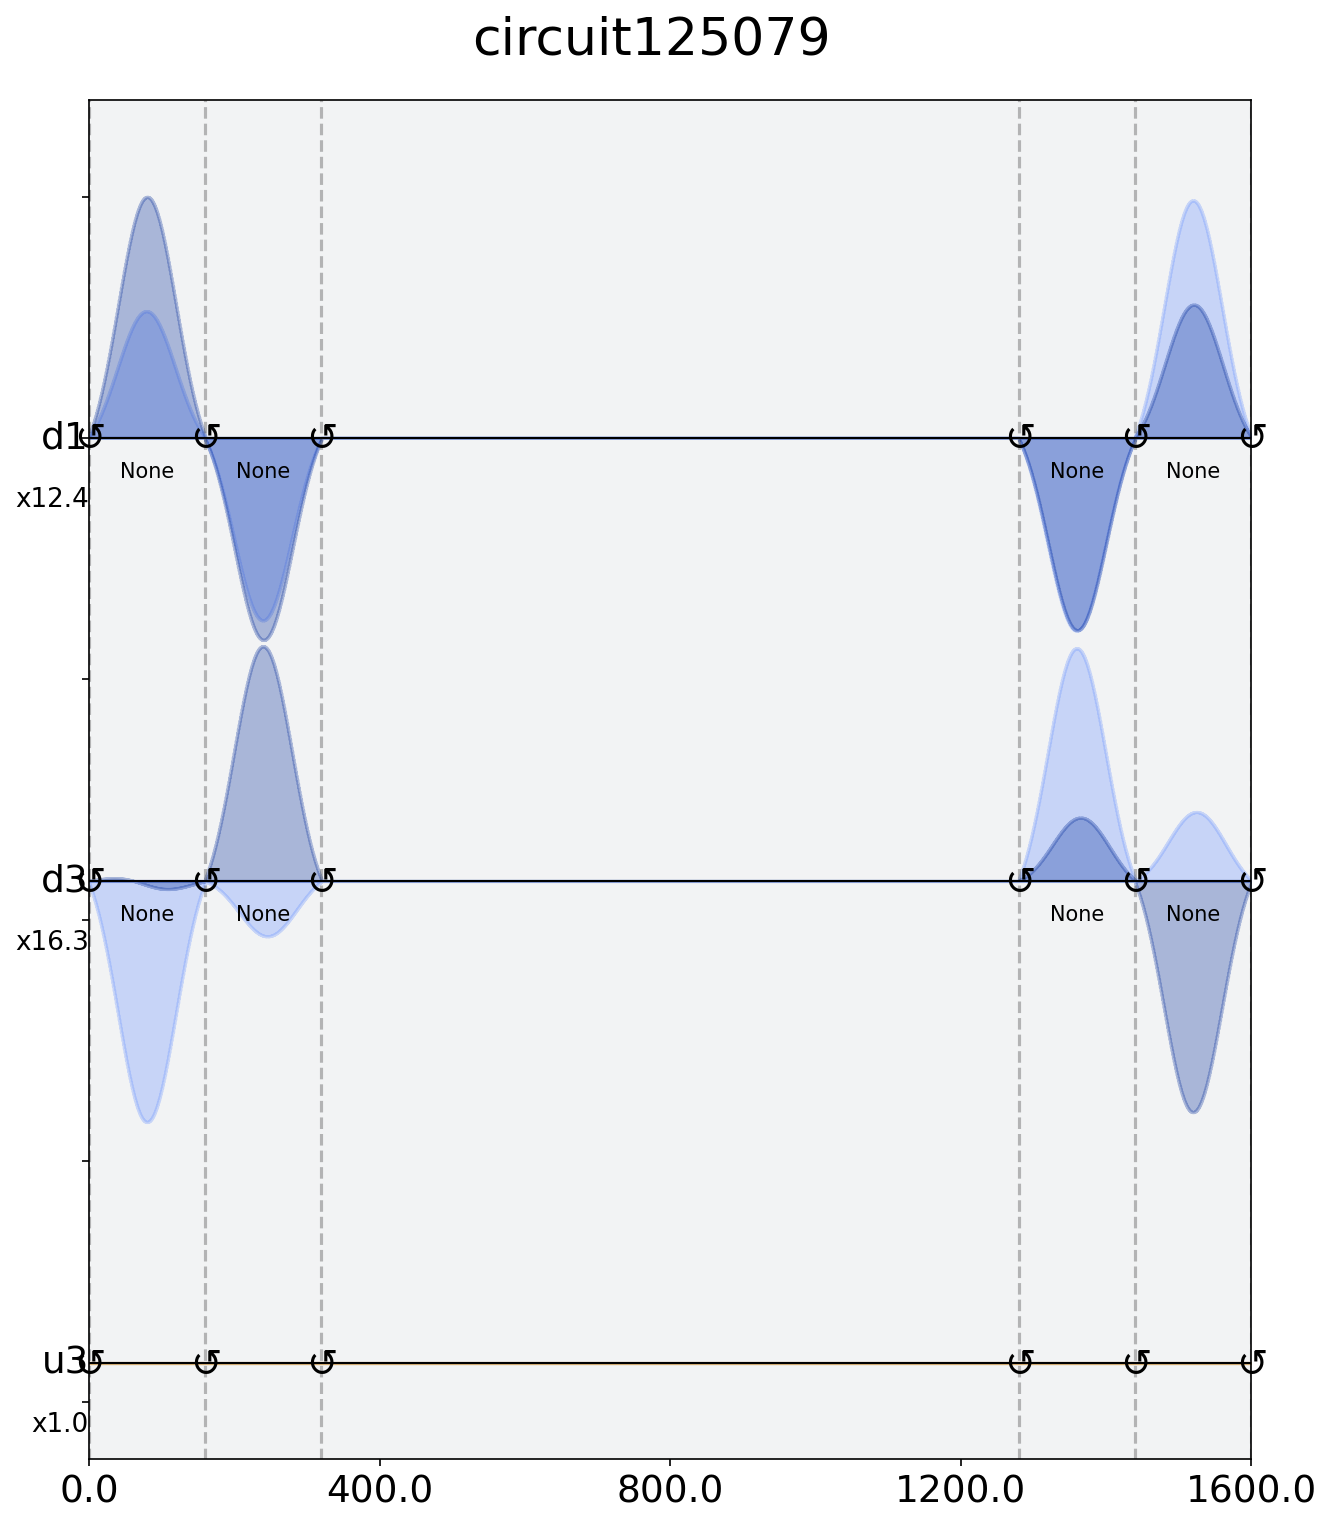

In [109]:
cr1_cnot_f_sched = schedule(cr1_cnot_f, backend, inst_map=ext_inst_map_cr1)
if not use_cache:
    with open('%s/sched_cr1_cnot_f.pk' % data_dir, 'wb') as fp:
        pickle.dump(cr1_cnot_f_sched, fp)
        
cr1_cnot_f_sched.draw(channels=channels, table=False, label=True)

In [110]:
# optimize local U3 rotations to realize CNOT: CR1 reverse order (control, target)
if use_cache:
    with open('%s/cr1_cnot_b_params.npy' % data_dir, 'rb') as fp:
        cr1_cnot_b_params = np.load(fp)
else:
    cr1_cnot_b_params = local_fidelity_optimization(cr1_choi_opt, ref_cnot_b_oper)
    np.save('%s/cr1_cnot_b_params.npy' % data_dir, cr1_cnot_b_params)

cr1_cnot_b = optimize_circuit(cr1_circ_zx90, control, target, cr1_cnot_b_params)
cr1_cnot_b.draw(fold=-1, idle_wires=False)

Original F_avg: 0.39961
Optimized F_avg: 0.60252


┌─────────────────────────────┐┌──────────┐┌─────────────────────────────┐
q0_1: ┤ U3(-1.4147,-0.88366,3.1172) ├┤0         ├┤ U3(1.6171,-2.9702,-0.68617) ├
      ├─────────────────────────────┤│  zx_p(0) │├─────────────────────────────┤
q0_3: ┤ U3(2.9483,-2.4112,-0.82528) ├┤1         ├┤ U3(2.9582,-0.6139,-0.63613) ├
      └─────────────────────────────┘└──────────┘└─────────────────────────────┘

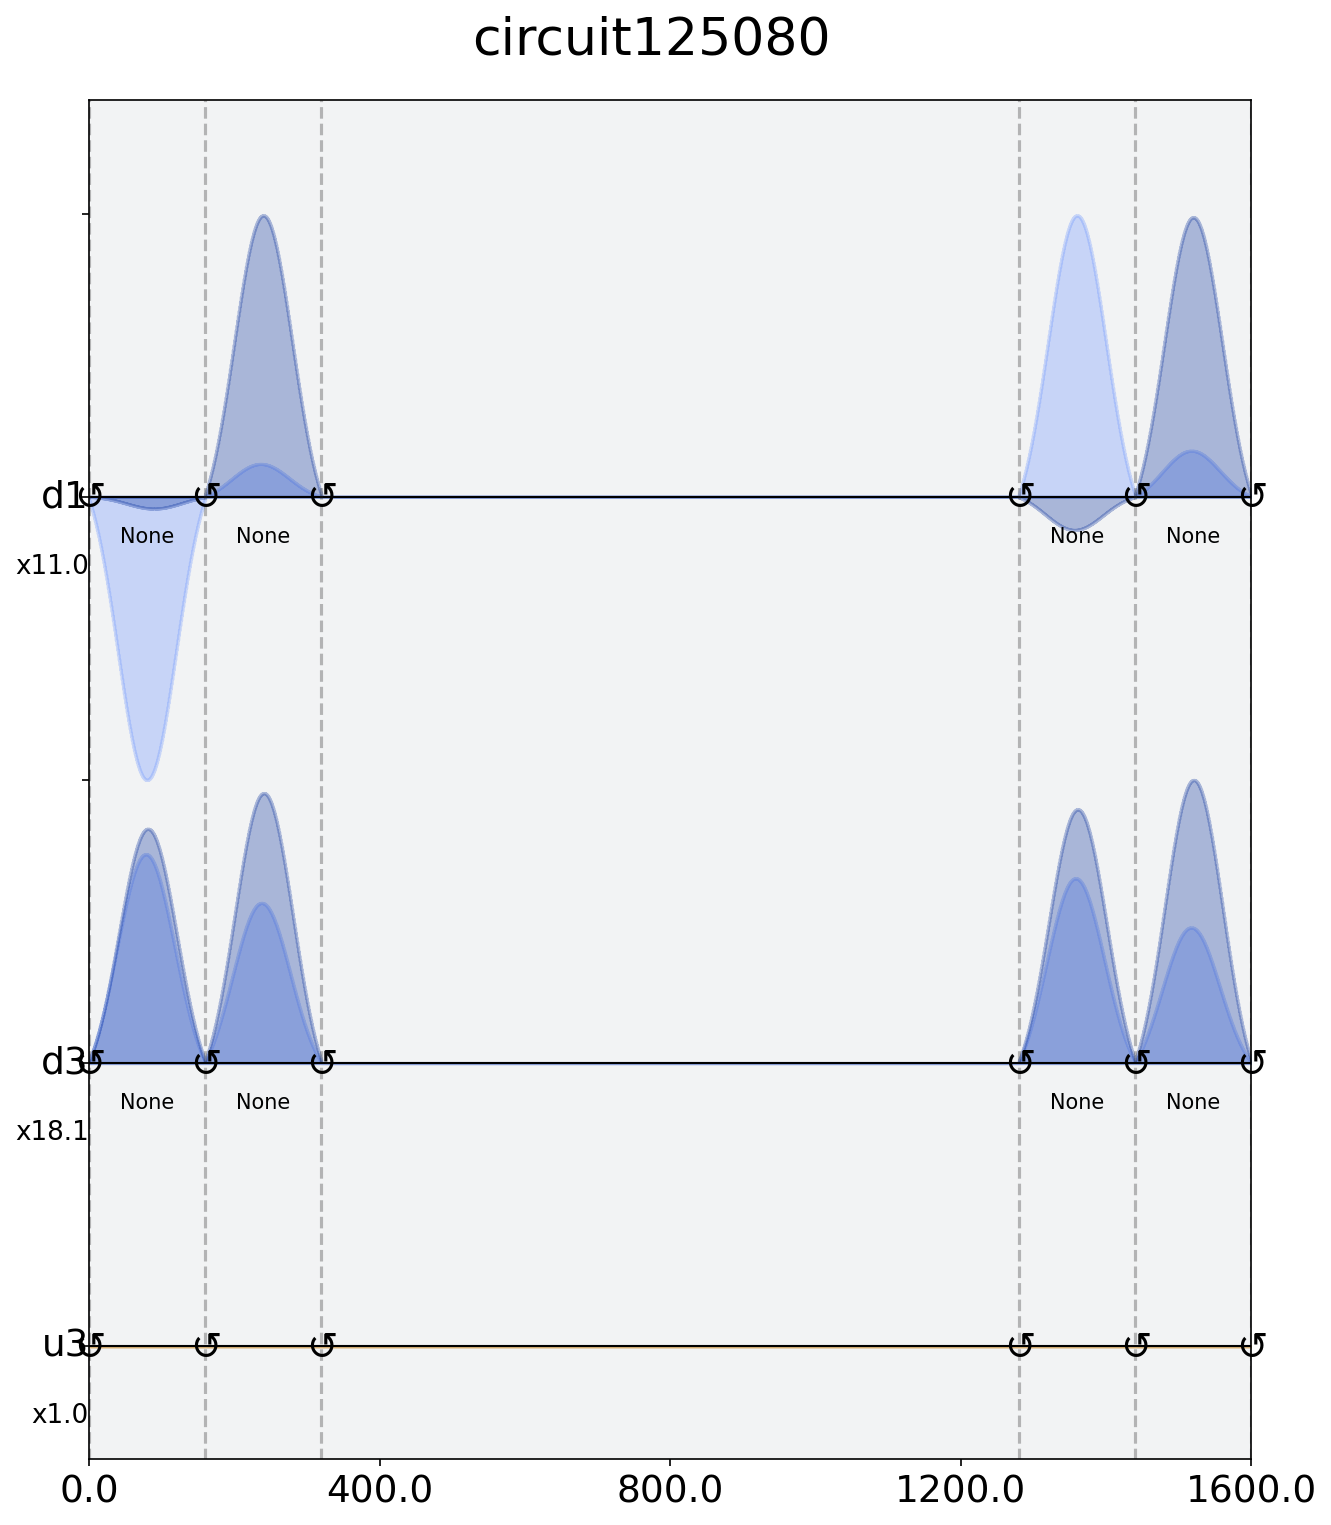

In [111]:
cr1_cnot_b_sched = schedule(cr1_cnot_b, backend, inst_map=ext_inst_map_cr1)
if not use_cache:
    with open('%s/sched_cr1_cnot_b.pk' % data_dir, 'wb') as fp:
        pickle.dump(cr1_cnot_b_sched, fp)
        
cr1_cnot_b_sched.draw(channels=channels, table=False, label=True)

In [112]:
# optimize local U3 rotations to realize CNOT: CR2 forward order(control, target)
if use_cache:
    with open('%s/cr2_cnot_f_params.npy' % data_dir, 'rb') as fp:
        cr2_cnot_f_params = np.load(fp)
else:
    cr2_cnot_f_params = local_fidelity_optimization(cr2_choi_opt, ref_cnot_f_oper)
    np.save('%s/cr2_cnot_f_params.npy' % data_dir, cr2_cnot_f_params)

cr2_cnot_f = optimize_circuit(cr2_circ_zx90, control, target, cr2_cnot_f_params)
cr2_cnot_f.draw(fold=-1, idle_wires=False)

Original F_avg: 0.39958
Optimized F_avg: 0.60331


┌───────────────────────────┐┌────────────────────────────┐┌───┐┌────────────────────────────┐            ┌───┐            ┌─────────────────────────────┐
q0_1: ┤ U3(1.9314,1.5838,0.63975) ├┤0                           ├┤ X ├┤0                           ├────────────┤ X ├────────────┤ U3(-1.9011,0.93735,-1.6084) ├
      └┬─────────────────────────┬┘│  zx_p(0.00361768292324051) │└───┘│  zx_m(0.00361768292324051) │┌───────────┴───┴───────────┐└─────────────────────────────┘
q0_3: ─┤ U3(-1.294,-2.99,2.6895) ├─┤1                           ├─────┤1                           ├┤ U3(1.9736,-2.8375,1.5147) ├───────────────────────────────
       └─────────────────────────┘ └────────────────────────────┘     └────────────────────────────┘└───────────────────────────┘

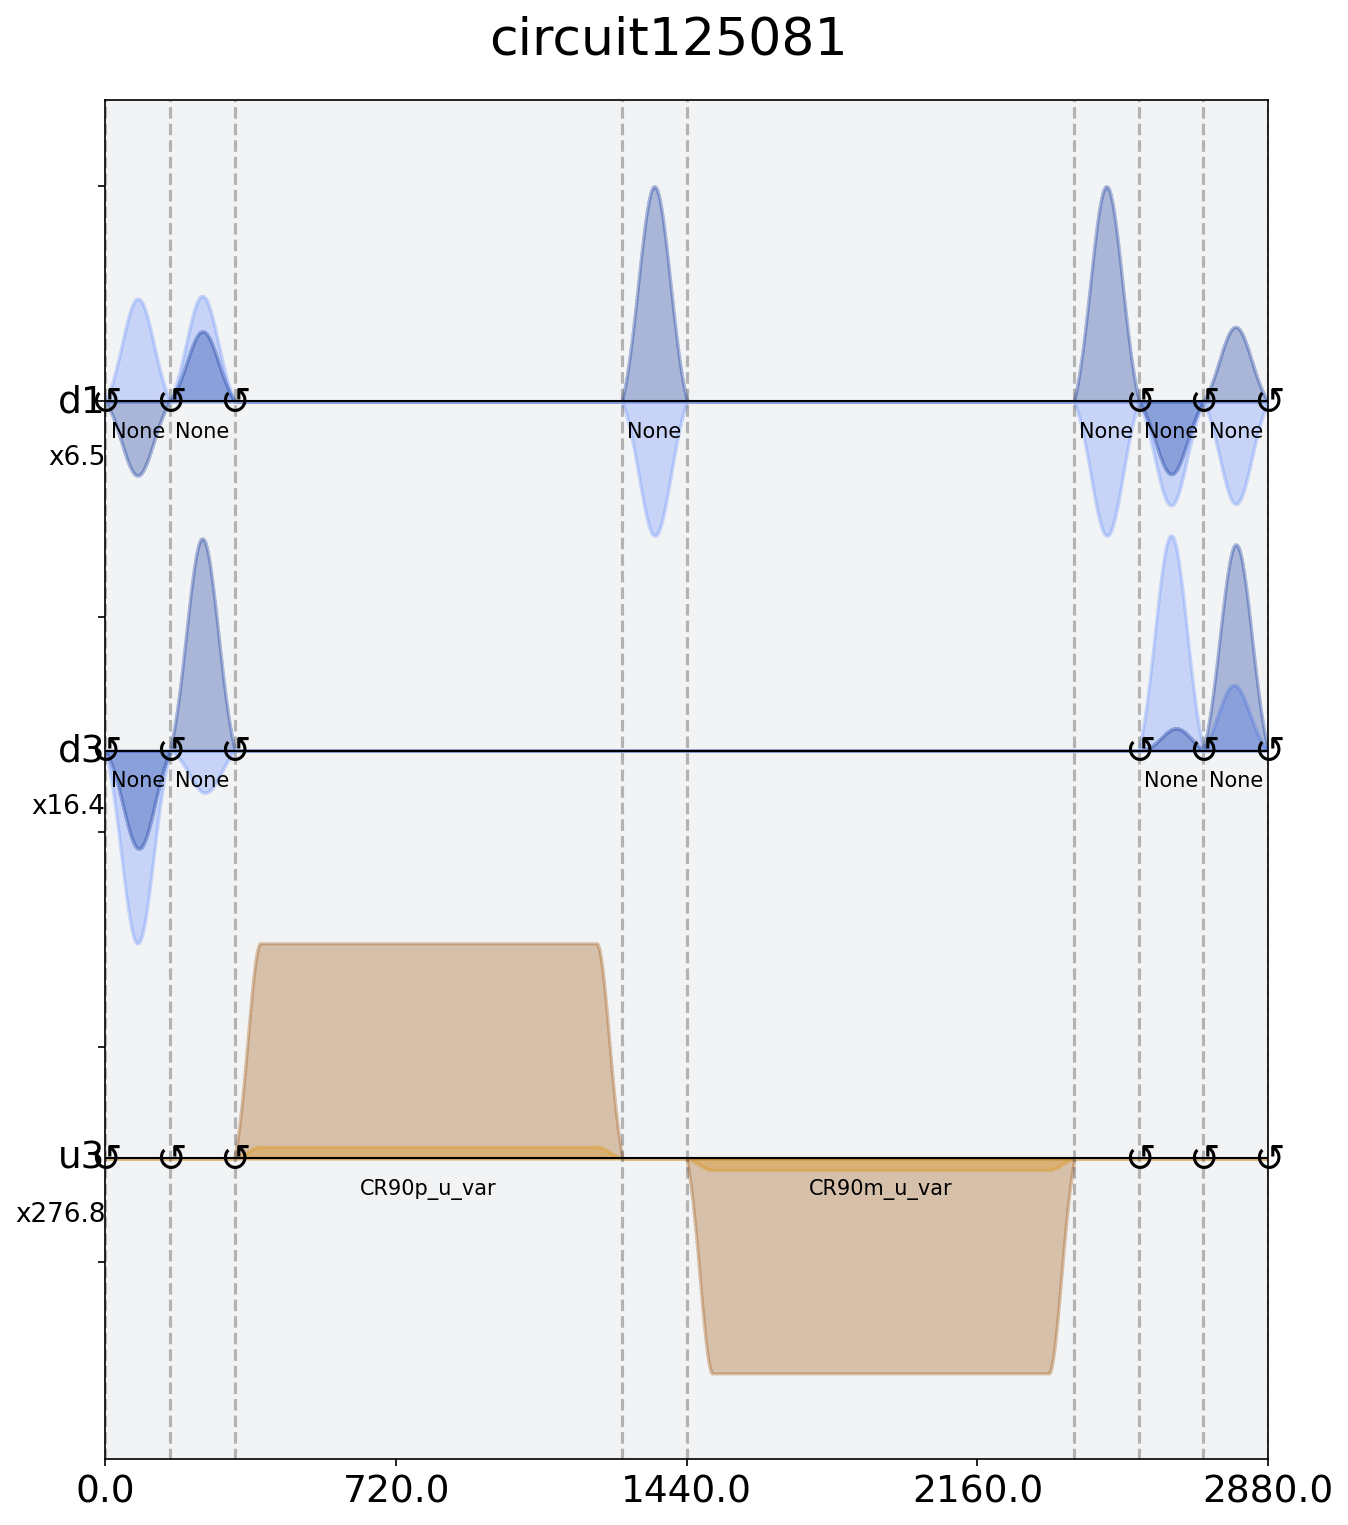

In [113]:
cr2_cnot_f_sched = schedule(cr2_cnot_f, backend, inst_map=ext_inst_map_cr2)
if not use_cache:
    with open('%s/sched_cr2_cnot_f.pk' % data_dir, 'wb') as fp:
        pickle.dump(cr2_cnot_f_sched, fp)
        
cr2_cnot_f_sched.draw(channels=channels, table=False, label=True)

In [114]:
# optimize local U3 rotations to realize CNOT: CR2 reverse order(target, control)
if use_cache:
    with open('%s/cr2_cnot_b_params.npy' % data_dir, 'rb') as fp:
        cr2_cnot_b_params = np.load(fp)
else:
    cr2_cnot_b_params = local_fidelity_optimization(cr2_choi_opt, ref_cnot_b_oper)
    np.save('%s/cr2_cnot_b_params.npy' % data_dir, cr2_cnot_b_params)
    
cr2_cnot_b = optimize_circuit(cr2_circ_zx90, control, target, cr2_cnot_b_params)
cr2_cnot_b.draw(fold=-1, idle_wires=False)

Original F_avg: 0.39990
Optimized F_avg: 0.60258


┌────────────────────────────┐┌────────────────────────────┐┌───┐┌────────────────────────────┐           ┌───┐            ┌───────────────────────────┐
q0_1: ┤ U3(1.4957,-2.9014,-1.2828) ├┤0                           ├┤ X ├┤0                           ├───────────┤ X ├────────────┤ U3(-2.8751,0.2388,1.5329) ├
      └┬─────────────────────────┬─┘│  zx_p(0.00361768292324051) │└───┘│  zx_m(0.00361768292324051) │┌──────────┴───┴───────────┐└───────────────────────────┘
q0_3: ─┤ U3(-π,-1.6307,-0.19009) ├──┤1                           ├─────┤1                           ├┤ U3(3.1167,1.9162,1.7503) ├─────────────────────────────
       └─────────────────────────┘  └────────────────────────────┘     └────────────────────────────┘└──────────────────────────┘

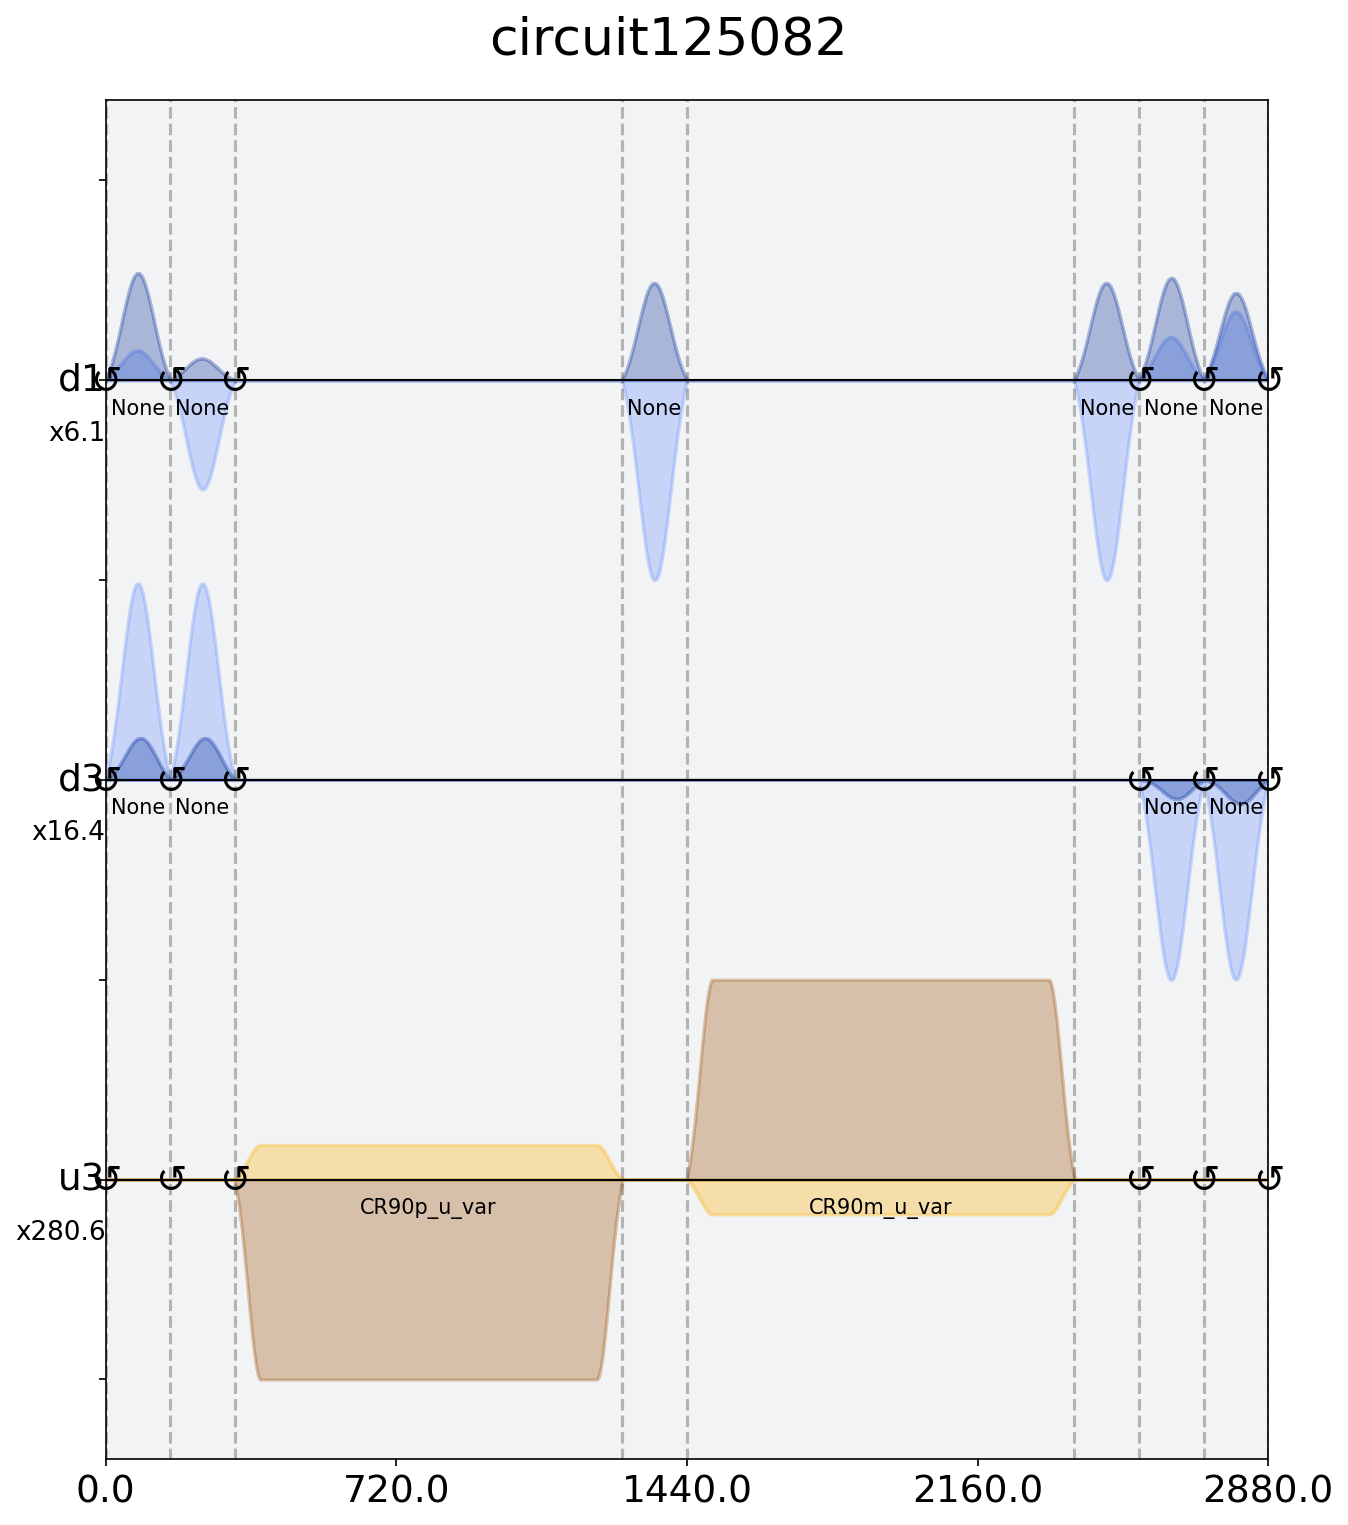

In [115]:
cr2_cnot_b_sched = schedule(cr2_cnot_b, backend, inst_map=ext_inst_map_cr2)
if not use_cache:
    with open('%s/sched_cr2_cnot_b.pk' % data_dir, 'wb') as fp:
        pickle.dump(cr2_cnot_b_sched, fp)
        
cr2_cnot_b_sched.draw(channels=channels, table=False, label=True)

In [116]:
qubit_layout = {ref_cnot_f.qregs[0][control_logical_ind]: control, ref_cnot_f.qregs[0][target_logical_ind]: target}

routed_ref_cnot_f = transpile(ref_cnot_f, backend, initial_layout=qubit_layout, optimization_level=0)
routed_ref_cnot_b = transpile(ref_cnot_b, backend, initial_layout=qubit_layout, optimization_level=0)

In [117]:
# create QPT schedules to evaluate fidelity of optimized schedules
cr1_cnot_qpt, qcs1, meas_labels = create_qpt_experiment(
    target_circuits=[cr1_cnot_f, cr1_cnot_b],
    control=control,
    target=target,
    backend=backend,
    mit_readout=True,
    inst_map=ext_inst_map_cr1,
    basis_gate=ext_basis_gates_cr1,
    shots=shots, 
    return_schedule=True
)

cr2_cnot_qpt, qcs2, _ = create_qpt_experiment(
    target_circuits=[cr2_cnot_f, cr2_cnot_b],
    control=control,
    target=target,
    backend=backend,
    mit_readout=False,
    inst_map=ext_inst_map_cr2,
    basis_gate=ext_basis_gates_cr2,
    shots=shots, 
    return_schedule=True
)

backend_cnot_qpt, qcs3, _ = create_qpt_experiment(
    target_circuits=[routed_ref_cnot_f, routed_ref_cnot_b],
    control=control,
    target=target,
    backend=backend,
    mit_readout=False,
    inst_map=ext_inst_map_cr2,
    basis_gate=ext_basis_gates_cr2,
    shots=shots, 
    return_schedule=True
)

# combine two QPT experiments and readout error mitigation experiments
bind_scheds = align_measures(cr1_cnot_qpt + cr2_cnot_qpt + backend_cnot_qpt, max_calibration_duration=0)
bind_qcs = qcs1 + qcs2 + qcs3

qobj_5_2 = qiskit.assemble(bind_scheds, backend=backend, meas_level=2, shots=shots)

In [118]:
#result_5_2 = runner.run(qobj_5_2, '5-2_qpt_cnot')

In [ ]:
jobid_5_2 = '606311943b6c040b94994052'
job_5_2 = backend.retrieve_job(jobid_5_2)
job_monitor(job_5_2)
#result_5_2 = job_5_2.result()

Job Status: job is queued (814) [Est. wait time: 1 days 8 hrs]


# --------------------------------------------------------------------------------------------------------------
# Current state of work in progress: waiting for results from 5_2
# --------------------------------------------------------------------------------------------------------------

Analysis

In [ ]:
choi_mats = [choi for choi in extract_choi_matrix(result_5_2, bind_qcs, meas_labels)]

if not use_cache:
    # output data for future analysis.
    np.save('%s/5-2_cnot_choi_mat.npy' % data_dir, [choi_mat.data for choi_mat in choi_mats])

In [ ]:
print('CR1-CNOT (control, target) F_avg = %f' % qi.average_gate_fidelity(choi_mats[0],
                                                                         ref_cnot_f,
                                                                         require_cp=False))
print('CR1-CNOT (target, control) F_avg = %f' % qi.average_gate_fidelity(choi_mats[1],
                                                                         ref_cnot_b,
                                                                         require_cp=False))

print('CR2-CNOT (control, target) F_avg = %f' % qi.average_gate_fidelity(choi_mats[2],
                                                                         ref_cnot_f,
                                                                         require_cp=False))
print('CR2-CNOT (target, control) F_avg = %f' % qi.average_gate_fidelity(choi_mats[3],
                                                                         ref_cnot_b,
                                                                         require_cp=False))

print('Backend CNOT (control, target) F_avg = %f' % qi.average_gate_fidelity(choi_mats[4],
                                                                             ref_cnot_f,
                                                                             require_cp=False))
print('Backend CNOT (target, control) F_avg = %f' % qi.average_gate_fidelity(choi_mats[5],
                                                                             ref_cnot_b,
                                                                             require_cp=False))

In [ ]:
# Chi matrix of CNOT (control, target), from the top: CR1, CR2, Backend
n_exp = 3
plt.figure(figsize=(15, 15 * n_exp))
axs_r = [plt.subplot(2*n_exp, 2, 1 + 2*ii) for ii in range(n_exp)]
axs_i = [plt.subplot(2*n_exp, 2, 2 + 2*ii) for ii in range(n_exp)]
plot_quantum_channel([choi_mats[0], choi_mats[2], choi_mats[4]], axs_r, axs_i)
plt.show()

In [ ]:
# Chi matrix of CNOT (target, control), from the top: CR1, CR2, Backend
n_exp = 3
plt.figure(figsize=(15, 15 * n_exp))
axs_r = [plt.subplot(2*n_exp, 2, 1 + 2*ii) for ii in range(n_exp)]
axs_i = [plt.subplot(2*n_exp, 2, 2 + 2*ii) for ii in range(n_exp)]
plot_quantum_channel([choi_mats[1], choi_mats[3], choi_mats[5]], axs_r, axs_i)
plt.show()

# 6. RB fidelity

Setup

In [ ]:
shots = 1024

n_seeds = 5
n_cliffs = np.arange(1, 200, 20)

In [ ]:
# create 1Q RB sequences
rb_patterns_1q = [[cr_qubits[0]], [cr_qubits[1]]]
xdata_1q = np.array([n_cliffs, n_cliffs])

rb_1q_circs_seeds, _ = rb.randomized_benchmarking_seq(length_vector=n_cliffs,
                                                      nseeds=n_seeds,
                                                      rb_pattern=rb_patterns_1q,
                                                      rand_seed=31)

In [ ]:
# create 2Q RB sequences
rb_patterns_2q = [[cr_qubits[0], cr_qubits[1]]]
xdata_2q = np.array([n_cliffs])

rb_2q_circs_seeds, _ = rb.randomized_benchmarking_seq(length_vector=n_cliffs,
                                                      nseeds=n_seeds,
                                                      rb_pattern=rb_patterns_2q,
                                                      rand_seed=31)

## 6-1. Single qubit RB to investigate EPGs of single qubit basis gates

In [ ]:
qobj_6_1, rb_transpiled_circus = create_rb_experiment(
    rb_seed_circs=rb_1q_circs_seeds,
    control=control,
    target=target,
    backend=backend,
    shots=shots
)

In [ ]:
# run experiment
result_6_1 = runner.run(qobj_6_1, '6-1_rb_1q')

In [ ]:
['6061e706098cdf8055114aeb', '6061e70e6bc6ac15bea90a71', '6061e7156bc6ac6108a90a72', '6061e71c8653254466ae121b', '6061e72174b4b561a0d9a2c0']

Analysis

In [ ]:
rb_1q_fit = rb.fitters.RBFitter(result_6_1, cliff_lengths=xdata_1q, rb_pattern=rb_patterns_1q)

In [ ]:
plt.figure(figsize=(16, 10))

for ii in range(len(rb_patterns_1q)):
    ax = plt.subplot(len(rb_patterns_1q), 2, ii+1)
    rb_1q_fit.plot_rb_data(pattern_index=ii, ax=ax, show_plt=False)
    ax.set_title('RB of qubit %s' % rb_patterns_1q[ii], fontsize=20)

plt.show()

In [ ]:
# count gate per Clifford
gpc = rb.gates_per_clifford(
    transpiled_circuits_list=rb_transpiled_circus,
    clifford_lengths=n_cliffs,
    basis=['u1', 'u2', 'u3', 'cx'],
    qubits=cr_qubits
)
gpc

In [ ]:
# calculate 1Q EPGs
epg_q0 = rb.calculate_1q_epg(
    gate_per_cliff=gpc,
    epc_1q=rb_1q_fit.fit[0]['epc'],
    qubit=rb_patterns_1q[0][0]
)
epg_q1 = rb.calculate_1q_epg(
    gate_per_cliff=gpc,
    epc_1q=rb_1q_fit.fit[1]['epc'],
    qubit=rb_patterns_1q[1][0]
)

for qid, epg in enumerate([epg_q0, epg_q1]):
    for basis, val in epg.items():
        print('[Q%d] %s: %.3e' % (rb_patterns_1q[qid][0], basis, val))

## 6-2. Two qubit RB with CR1 CNOT

In [ ]:
qobj_6_2, rb_transpiled_circus = create_rb_experiment(
    rb_seed_circs=rb_2q_circs_seeds,
    control=control,
    target=target,
    backend=backend,
    cnot_sched_control_target=cr1_cnot_f_sched,
    cnot_sched_target_control=cr1_cnot_b_sched,
    shots=shots
)

In [ ]:
# run experiment
result_6_2 = runner.run(qobj_6_2, '6-2_rb_2q_cr1')

Analysis

In [ ]:
rb_2q_cr1_fit = rb.fitters.RBFitter(result_6_2, cliff_lengths=xdata_2q, rb_pattern=rb_patterns_2q)

In [ ]:
plt.figure(figsize=(8, 5))

ax = plt.subplot(111)
rb_2q_cr1_fit.plot_rb_data(pattern_index=0, ax=ax, show_plt=False)
ax.set_title('RB of qubit %s' % rb_patterns_2q[0], fontsize=20)

plt.show()

In [ ]:
# count gate per Clifford
gpc = rb.gates_per_clifford(
    transpiled_circuits_list=rb_transpiled_circus,
    clifford_lengths=n_cliffs,
    basis=['u1', 'u2', 'u3', 'cx'],
    qubits=cr_qubits
)
gpc

In [ ]:
# calculate 2Q EPG
epgs_2q_cr1 = rb.calculate_2q_epg(
    gate_per_cliff=gpc,
    epc_2q=rb_2q_cr1_fit.fit[0]['epc'],
    qubit_pair=cr_qubits,
    list_epgs_1q=[epg_q0, epg_q1]
)
1 - epgs_2q_cr1

## 6-3. Two qubit RB with CR2 CNOT

In [ ]:
qobj_6_3, rb_transpiled_circus = create_rb_experiment(
    rb_seed_circs=rb_2q_circs_seeds,
    control=control,
    target=target,
    backend=backend,
    cnot_sched_control_target=cr2_cnot_f_sched,
    cnot_sched_target_control=cr2_cnot_b_sched,
    shots=shots
)

In [ ]:
# run experiment
result_6_3 = runner.run(qobj_6_3, '6-3_rb_2q_cr2')

Analysis

In [ ]:
rb_2q_cr2_fit = rb.fitters.RBFitter(result_6_3, cliff_lengths=xdata_2q, rb_pattern=rb_patterns_2q)

In [ ]:
plt.figure(figsize=(8, 5))

ax = plt.subplot(111)
rb_2q_cr2_fit.plot_rb_data(pattern_index=0, ax=ax, show_plt=False)
ax.set_title('RB of qubit %s' % rb_patterns_2q[0], fontsize=20)

plt.show()

In [ ]:
# calculate 2Q EPG
epgs_2q_cr2 = rb.calculate_2q_epg(
    gate_per_cliff=gpc,
    epc_2q=rb_2q_cr2_fit.fit[0]['epc'],
    qubit_pair=cr_qubits,
    list_epgs_1q=[epg_q0, epg_q1]
)
1 - epgs_2q_cr2

## 6-4. Two qubit RB with backend CNOT

In [ ]:
qobj_6_4, rb_transpiled_circus = create_rb_experiment(
    rb_seed_circs=rb_2q_circs_seeds,
    control=control,
    target=target,
    backend=backend,
    shots=shots
)

In [ ]:
# run experiment
#result_6_4 = runner.run(qobj_6_4, '6-4_rb_2q_back')

In [20]:
jobids_61_c3t1 = ["6061e7a274b4b5cc7ed9a2c4", "6061e7b3f0abf85d2937e853", 
                  "6061e7bf405f5c193989c713", "6061e7ca3b6c0485c5993462", "6061e7d6a2c2216620b458c4"]

Analysis

In [95]:
rb_2q_back_fit = rb.fitters.RBFitter(result_6_4, cliff_lengths=xdata_2q, rb_pattern=rb_patterns_2q)

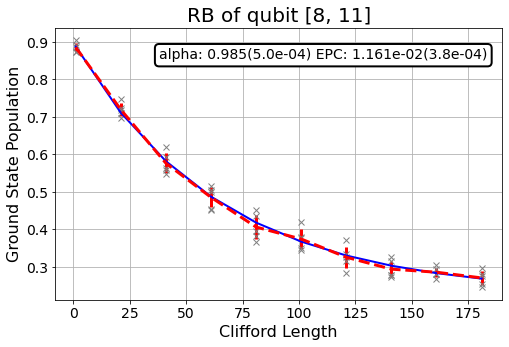

In [96]:
plt.figure(figsize=(8, 5))

ax = plt.subplot(111)
rb_2q_back_fit.plot_rb_data(pattern_index=0, ax=ax, show_plt=False)
ax.set_title('RB of qubit %s' % rb_patterns_2q[0], fontsize=20)

plt.show()

In [97]:
# calculate 2Q EPG
epgs_2q_back = rb.calculate_2q_epg(
    gate_per_cliff=gpc,
    epc_2q=rb_2q_back_fit.fit[0]['epc'],
    qubit_pair=cr_qubits,
    list_epgs_1q=[epg_q0, epg_q1]
)
1 - epgs_2q_back

0.9959343495450343

# 7. Fidelity Upperbounds

In [98]:
t1s = [experiment_conditions['target_qubit_t1'], experiment_conditions['control_qubit_t1']]
t2s = [experiment_conditions['target_qubit_t2'], experiment_conditions['control_qubit_t2']]

cr1_cnot_dur = cr1_cnot_f_sched.duration * config.dt
cr2_cnot_dur = cr2_cnot_f_sched.duration * config.dt
back_cnot_dur = experiment_conditions['backend_cnot_gate_length']

print('CR1 CNOT fidelity upper bound %.3e' % (1 - rb.coherence_limit(nQ=2, T1_list=t1s, T2_list=t2s, gatelen=cr1_cnot_dur)))
print('CR2 CNOT fidelity upper bound %.3e' % (1 - rb.coherence_limit(nQ=2, T1_list=t1s, T2_list=t2s, gatelen=cr2_cnot_dur)))
print('Backend CNOT fidelity upper bound %.3e' % (1 - rb.coherence_limit(nQ=2, T1_list=t1s, T2_list=t2s, gatelen=back_cnot_dur)))

CR1 CNOT fidelity upper bound 9.943e-01
CR2 CNOT fidelity upper bound 9.898e-01
Backend CNOT fidelity upper bound 9.928e-01


In [99]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright